In [4]:
# Install all required packages
# Run this cell once

!pip install whisperx pyannote.audio librosa speechbrain torchaudio pandas matplotlib seaborn python-dotenv soundfile


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Import all required libraries

# Core speech & audio libraries
import whisperx                          # Speech-to-text with speaker alignment
from pyannote.audio import Pipeline      # Speaker diarization (who spoke when)
import librosa                           # Audio loading & analysis
import librosa.display                   # Audio visualization (waveforms, spectrograms)
from speechbrain.pretrained import EncoderClassifier  # Emotion or speaker classification

# Deep learning & data handling
import torch                             # GPU acceleration (used by WhisperX / PyAnnote)
import pandas as pd                      # Dataframes for diarization/emotion results
import numpy as np                       # Numerical operations & signal processing

# Visualization
import matplotlib.pyplot as plt           # Plotting (timelines, charts, etc.)
import seaborn as sns                     # Prettier, themed plots

# Utilities & file handling
import os                                # File paths & environment management
import re                                # Regex for text cleaning or parsing
import tempfile                          # Temporary files for audio chunks
import soundfile as sf                   # Read/write WAV or FLAC audio files
from dotenv import load_dotenv           # Load API tokens / config from .env
from datetime import datetime            # For timestamps & logging


# Set plotting style
sns.set_style("whitegrid")                # Clean white background with grid
plt.rcParams['figure.dpi'] = 100          # Higher resolution plots

# Load environment variables
load_dotenv()                             # Load from .env file if present
HF_TOKEN = os.getenv("HF_TOKEN")          # Hugging Face API token for PyAnnote

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"

print("=" * 70)
print("SPEAKSENSE - MEDIA BIAS DETECTION DASHBOARD")
print("=" * 70)
print(f"\nAll libraries imported")
print(f"Device: {device.upper()}")                                     # Log device being used
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")    # Log current time                                             
print("\n" + "=" * 70)

SPEAKSENSE - MEDIA BIAS DETECTION DASHBOARD

All libraries imported
Device: CPU
Timestamp: 2025-11-12 20:28:24



Loading: ../data/US_DebateAudio.wav

Audio loaded successfully
  Sample rate: 44100 Hz
  Duration: 565.78s (9.43 min)
  Shape: (24950784,)


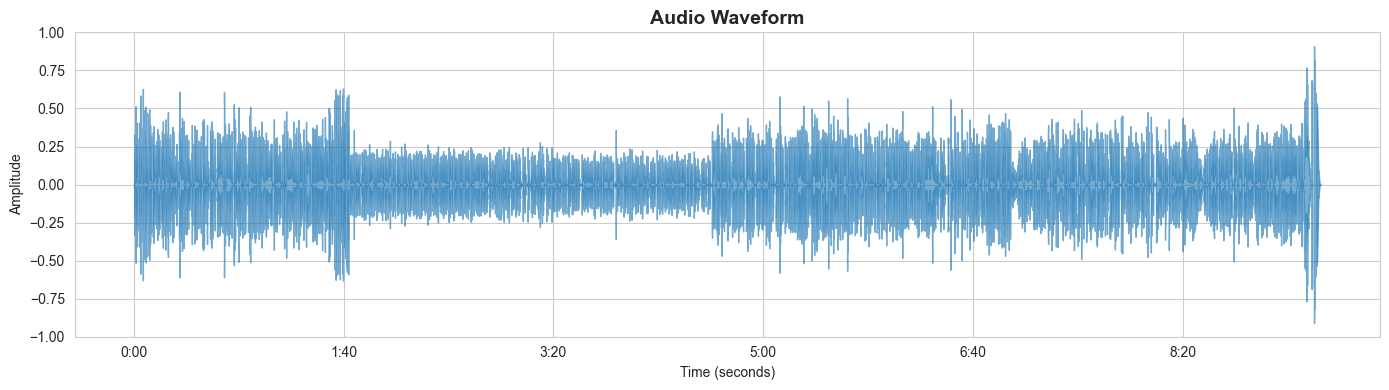

In [6]:
# Audio file path
audio_file = "../data/US_DebateAudio.wav"

print(f"Loading: {audio_file}")

# Load audio with librosa
audio, sample_rate = librosa.load(audio_file, sr=None)
duration = len(audio) / sample_rate                     # Calculate total duration in seconds


print(f"\nAudio loaded successfully")
print(f"  Sample rate: {sample_rate} Hz")
print(f"  Duration: {duration:.2f}s ({duration/60:.2f} min)")
print(f"  Shape: {audio.shape}")

# Quick visualization - Plot waveform

plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio, sr=sample_rate, alpha=0.6, color='#1f77b4')
plt.title('Audio Waveform', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

In [ ]:
print("=" * 70)
print("SPEAKER DIARIZATION")
print("=" * 70)

# Load the pre-trained diarization model from Hugging Face
print("\n[1/2] Loading diarization model...")
diarize_model = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",
    use_auth_token=HF_TOKEN
)

# Run the diarization pipeline on the audio file
print("[2/2] Running speaker diarization...")
diarize_segments = diarize_model(audio_file)

# Convert to DataFrame
diarize_list = []
for turn, _, speaker in diarize_segments.itertracks(yield_label=True):
    diarize_list.append({
        'start': turn.start,
        'end': turn.end,
        'speaker': speaker,
        'duration': turn.end - turn.start
    })
diarize_df = pd.DataFrame(diarize_list)

# Summary statistics
num_speakers = len(diarize_df['speaker'].unique())
print(f"\nDiarization complete!")
print(f"  Speakers identified: {num_speakers}")
print(f"  Total segments: {len(diarize_df)}")
print(f"\nFirst few segments:")
print(diarize_df.head(10))

SPEAKER DIARIZATION

[1/2] Loading diarization model...


c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\core\io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.list_audio_backends()


[2/2] Running speaker diarization...


c:\Users\norak\SpeakSense\venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  std = sequences.std(dim=-1, correction=1)
c:\Users\norak\SpeakSense\venv\Lib\site-packages\pyannote\audio\c

In [ ]:
print("=" * 70)
print("TRANSCRIPTION & ALIGNMENT")
print("=" * 70)

# Load WhisperX model (for speech-to-text)
# "base" is a small, efficient model
print("\n[1/3] Loading WhisperX model...")
model = whisperx.load_model("base", device=device, compute_type="int8" if device=="cpu" else "float16")

# Transcribe the full audio into text segments
print("[2/3] Transcribing audio...")
result = model.transcribe(audio_file)

# Align transcription with word-level timestamps for accuracy
# Adds start/end times to each word in the transcript
print("[3/3] Aligning to word-level timestamps...")
model_a, metadata = whisperx.load_align_model(language_code="en", device=device)
result = whisperx.align(result["segments"], model_a, metadata, audio_file, device=device)

print("\nTranscription complete!")
print(f"  Segments: {len(result['segments'])}")
print(f"\nFirst segment preview:")
print(f"  {result['segments'][0].get('text', '')[:100]}...")

In [ ]:
print("\n" + "=" * 70)
print("ASSIGNING SPEAKERS TO TRANSCRIPT")
print("=" * 70)

# Combine diarization output with transcription
# Each word/segment now includes a speaker label (who said what)
result = whisperx.assign_word_speakers(diarize_df, result)

print("\nSpeakers assigned to transcript!")
print(f"  Total segments with speakers: {sum(1 for s in result['segments'] if 'speaker' in s)}")

In [ ]:
print("=" * 70)
print("SPEAKER TIME SHARE ANALYSIS")
print("=" * 70)

# Calculate total speaking time per speaker
speaker_time = diarize_df.groupby('speaker')['duration'].sum()
total_time = speaker_time.sum()
speaker_percentages = (speaker_time / total_time * 100).round(2)

# Print statistics
print("\nSpeaking Time Breakdown:")
for speaker, time in speaker_time.items():
    percentage = speaker_percentages[speaker]
    minutes = time / 60
    print(f"  {speaker}: {minutes:.2f} min ({percentage}%)")

# Create pie chart
plt.figure(figsize=(10, 8))
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#ffd93d', '#95e1d3']
explode = [0.05] * len(speaker_time)

wedges, texts, autotexts = plt.pie(
    speaker_time, 
    labels=[f"{s}\n{speaker_percentages[s]}%" for s in speaker_time.index],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(speaker_time)],
    explode=explode,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Make percentage text white and bold for readability
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)

plt.title('Speaker Time Share - Who Dominated the Conversation?', 
          fontsize=15, fontweight='bold', pad=20)
plt.axis('equal') # Keep pie chart circular
plt.tight_layout()
plt.show()